Replicate EV/REV plots for Octopamine/Rolipram sessions previously generated by Jahangir.

In [3]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform
import scipy.stats as stats

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
    sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy.core.neurons import Neurons
from neuropy.analyses.reactivation import ExplainedVariance
from neuropy.core.epoch import Epoch
from neuropy.core.session import ProcessData
from neuropy.plotting import plot_epochs, Fig
from neuropy.utils.plot_util import match_axis_lims

import subjects
from plotters import Plotter
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

import ev_utils

grp_data_dir = Path("/data3/Octopamine_Rolipram/GroupData")
plot_save_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_octopamine_rollipram/Nat_plots')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Set up colors and rough injection times (from Jahangir plots)

In [4]:
sesh_csv = "/data3/Octopamine_Rolipram/Recording_Rats/OCT_ROL_sessions.csv"
sesh_df = pd.read_csv(sesh_csv, header=0)
sesh_df['session'] = pd.Categorical(sesh_df['session'], ['PBS', 'SAL', 'ROL', 'OCT'])
sesh_df = sesh_df.sort_values(["Animal", "session"]).reset_index().drop(columns = "index")
sesh_df

,Animal,session,date,directory,processed,inject 1,inject 2,accuracy
0,A11,PBS,2019_12_02,/data3/Octopamine_Rolipram/Recording_Rats/A11/...,Y,4.8,6.3,guess
1,A11,ROL,2019_12_12,/data3/Octopamine_Rolipram/Recording_Rats/A11/...,Y,4.8,6.3,guess
2,A11,OCT,2019_11_30,/data3/Octopamine_Rolipram/Recording_Rats/A11/...,Y,4.8,6.3,guess
3,A14,PBS,2020_02_23,/data3/Octopamine_Rolipram/Recording_Rats/A14/...,Y,4.7,6.2,from_plot
4,A14,ROL,2020_02_26,/data3/Octopamine_Rolipram/Recording_Rats/A14/...,Y,5.0,6.5,from_plot
5,A14,OCT,2020_02_21,/data3/Octopamine_Rolipram/Recording_Rats/A14/...,Y,4.8,6.3,guess
6,BG,SAL,2019_10_21,/data3/Octopamine_Rolipram/Recording_Rats/BG/B...,Y,4.8,6.3,from_plot
7,BG,ROL,2019_10_19,/data3/Octopamine_Rolipram/Recording_Rats/BG/B...,Y,4.9,6.4,from_plot
8,BG,OCT,None,None,N,NaN,NaN,NaN
9,BGU,SAL,2021_08_11,/data3/Octopamine_Rolipram/Recording_Rats/BGU/...,Y,4.7,6.2,from_plot


In [5]:
colors_rs = "#5599ff"
colors_nsd = "k"
colors_sd = "#eb4034"
colors_maze = "g"
colors_pre = "#424242"
colors_sd_all = [colors_pre, colors_maze, colors_sd, colors_rs]

def adjust_lightness(color, amount=0.5):
    import colorsys

    import matplotlib.colors as mc

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    c = colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    return mc.to_hex(c)

colors_all_light = [adjust_lightness(col, 1.2) for col in colors_sd_all]
colors_grp = [colors_sd, colors_pre]
colors_grp_light = [adjust_lightness(col, 1.2) for col in colors_grp]

## Bootstrap sessions

First calculate pairwise correlations for each session

In [92]:
# Update sesh_df to have same term for controls
sesh_df["session_type"] = sesh_df.session.apply(lambda session_id: 'PBS/SAL' if session_id in ["PBS", "SAL"] else session_id)

pcorr_df = []
sub = 0
for session_type in ["PBS/SAL", "ROL"]:
    sesh_type_df = sesh_df[sesh_df.session_type == session_type]
    for ida, animal in enumerate(sesh_type_df.Animal.unique()):
        rec_df = sesh_type_df[sesh_type_df.Animal == animal]
        if (rec_df.directory.values[0] == "None") or (rec_df.processed.values[0] == "N"):
            pass
        else:
            dir_use = Path(str(rec_df["directory"].values[0]))
            neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
            neurons_use = neurons_use.get_neuron_type(["pyr", "good", "1"])
            epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])

            # Make epochs class with PRE, MAZE, 0-2.5, 2.5-5, and 5-7.5
            blk1 = [epochs["sd"].starts[0], epochs["sd"].starts[0] + 3600*2.5, "0-2.5", np.nan]
            blk2 = [epochs["sd"].starts[0] + 3600*2.5, epochs["sd"].starts[0] + 3600*5, "2.5-5", np.nan]
            blk3 = [epochs["sd"].stops[0], epochs["post"].starts[0] + 3600*2.5, "5-7.5", np.nan]
            epochs_df = deepcopy(epochs.to_dataframe())
            for blk in [blk1, blk2, blk3]:
                epochs_df.loc[-1] = blk
                epochs_df.index = epochs_df.index + 1  # shifting index
                epochs_df = epochs_df.sort_index() 
            for lcasename in ["pre", "post", "sd", "maze"]:
                epochs_df.loc[epochs_df.label == lcasename, "label"] = lcasename.upper()
            zt_epochs = Epoch(epochs_df)[["PRE", "MAZE", "0-2.5", "2.5-5", "5-7.5"]]
            
            pcorr, labels = ev_utils.get_pcorr(neurons=neurons_use, epochs=zt_epochs)
            df = pd.DataFrame(data=pcorr, columns=labels)
        
            df["session"] = sub
            df["Animal"] = rec_df.Animal.values[0]
            sub += 1
            df["grp"] = session_type
            pcorr_df.append(df)

pcorr_df = pd.concat(pcorr_df, ignore_index=True)
np.save(grp_data_dir / "pcorrs.npy", pcorr_df, allow_pickle=True)

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid v

Now bootstrap them!

In [51]:
# Load in pcorrs for each neuron pair - somehow this doesn't work for bootstrapping below!
pcorr_df2 = pd.DataFrame(np.load(grp_data_dir / "pcorrs.npy", allow_pickle=True), 
                        columns=["PRE", "MAZE", "0-2.5", "2.5-5", "5-7.5", "session", "grp"])
pcorr_df2

,PRE,MAZE,0-2.5,2.5-5,5-7.5,session,grp
0,-0.001153,-0.000774,NaN,0.029837,0.010462,0,PBS/SAL
1,-0.001583,NaN,-0.001965,0.046854,0.002411,0,PBS/SAL
2,-0.000062,NaN,NaN,-0.000514,0.030831,0,PBS/SAL
3,-0.005472,0.016386,0.075424,0.027743,0.012109,0,PBS/SAL
4,0.007158,-0.002079,NaN,-0.001386,-0.009769,0,PBS/SAL
...,...,...,...,...,...,...,...
67379,NaN,-0.00155,0.053033,0.113274,0.103414,9,ROL
67380,NaN,NaN,0.110933,0.030457,0.0558,9,ROL
67381,NaN,-0.003741,-0.002715,0.024543,0.227267,9,ROL
67382,NaN,0.028312,-0.001168,0.050023,0.181747,9,ROL


In [91]:
rec_df.Animal.values[0]

'MR10'

In [93]:
pcorr_df[pcorr_df.session == 5].count()

PRE        1
MAZE       1
0-2.5      1
2.5-5      1
5-7.5      1
session    1
Animal     1
grp        1
dtype: int64

In [80]:
session 

5

In [104]:
ev_chunk_df = []
for session in pcorr_df.session.unique():
    df_use = pcorr_df[pcorr_df.session == session]
    try:
        ev_df = get_ev(df_use)
        ev_df["session"] = session
        ev_df["Animal"] = df_use.Animal.unique()[0]
        ev_df["grp"] = df_use.grp.unique()[0]
        ev_df["npairs"] = df_use.count().max()
        ev_chunk_df.append(ev_df)
    except ValueError:  # Happens if there is only 1 neuron
        
        print(f"Skipping session {session} with only {df_use.count()[0]} neuron-pair")
ev_chunk_df = pd.concat(ev_chunk_df, axis=0, ignore_index=True)
ev_chunk_df

Skipping session 5 with only 1 neuron-pair


,zt,ev,session,Animal,grp,npairs
0,0-2.5,0.537234,0,A11,PBS/SAL,21
1,2.5-5,0.731584,0,A11,PBS/SAL,21
2,5-7.5,0.041705,0,A11,PBS/SAL,21
3,0-2.5,0.065373,1,A14,PBS/SAL,4473
4,2.5-5,0.040278,1,A14,PBS/SAL,4473
5,5-7.5,0.047912,1,A14,PBS/SAL,4473
6,0-2.5,0.094267,2,BG,PBS/SAL,2087
7,2.5-5,0.014596,2,BG,PBS/SAL,2087
8,5-7.5,0.109814,2,BG,PBS/SAL,2087
9,0-2.5,0.091048,3,BGU,PBS/SAL,10687


In [100]:
df_use.count().max()

3589

In [64]:
from stats_utils import bootstrap_resample
from ev_utils import get_ev, get_ev_mean

# Remove sessions with less than specified number of pairs!
count_df = pcorr_df.groupby("session").count().reset_index()
npairs_thresh = 100
good_sesh = count_df["session"][count_df["grp"] >= npairs_thresh]
good_sesh_bool = pcorr_df.session.apply(lambda x: x in good_sesh)

kw = dict(df=pcorr_df[good_sesh_bool], n_iter=10000, n_jobs=10)

boot_df = bootstrap_resample(level="both", apply=get_ev, **kw)
boot_save_append = f"_min{npairs_thresh}pairs"
np.save(f"/data3/Octopamine_Rolipram/GroupData/ev_in_chunks_bootstrap{boot_save_append}.npy", boot_df, allow_pickle=True)

Running bootstraps for PBS/SAL group


  0%|                                                 | 0/10000 [00:00<?, ?it/s]/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outd

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

  9%|███▍                                  | 919/10000 [00:05<00:32, 276.31it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 10%|███▊                                 | 1025/10000 [00:05<00:33, 265.55it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 11%|████                                 | 1095/10000 [00:06<00:35, 251.25it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 12%|████▌                                | 1231/10000 [00:06<00:28, 311.26it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 13%|████▋                                | 1263/10000 [00:06<00:32, 265.84it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 18%|██████▌                              | 1759/10000 [00:08<00:31, 260.15it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 20%|███████▏                             | 1951/10000 [00:09<00:30, 263.75it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 21%|███████▋                             | 2091/10000 [00:09<00:30, 259.71it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 21%|███████▊                             | 2127/10000 [00:09<00:28, 274.45it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 22%|████████▎                            | 2247/10000 [00:10<00:29, 267.15it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 24%|████████▊                            | 2396/10000 [00:10<00:28, 263.63it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 29%|██████████▋                          | 2879/10000 [00:12<00:27, 256.83it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 31%|███████████▍                         | 3091/10000 [00:13<00:23, 293.09it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 31%|███████████▋                         | 3149/10000 [00:13<00:25, 269.62it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 33%|████████████▏                        | 3291/10000 [00:14<00:23, 287.07it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 35%|████████████▊                        | 3479/10000 [00:14<00:25, 253.65it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 39%|██████████████▍                      | 3915/10000 [00:16<00:21, 278.79it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 40%|██████████████▊                      | 3991/10000 [00:16<00:22, 271.97it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 41%|███████████████                      | 4084/10000 [00:17<00:21, 278.26it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 42%|███████████████▌                     | 4219/10000 [00:17<00:21, 274.89it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 43%|███████████████▉                     | 4295/10000 [00:17<00:21, 268.79it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 45%|████████████████▋                    | 4499/10000 [00:18<00:17, 307.11it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 49%|██████████████████▏                  | 4903/10000 [00:20<00:16, 305.72it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 50%|██████████████████▋                  | 5039/10000 [00:20<00:18, 268.52it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 51%|██████████████████▊                  | 5071/10000 [00:20<00:19, 253.73it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 52%|███████████████████▏                 | 5179/10000 [00:21<00:17, 269.32it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 53%|███████████████████▌                 | 5299/10000 [00:21<00:18, 257.14it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 55%|████████████████████▏                | 5467/10000 [00:22<00:17, 251.84it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 56%|████████████████████▌                | 5552/10000 [00:22<00:15, 289.92it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 57%|████████████████████▉                | 5667/10000 [00:22<00:14, 296.65it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 58%|█████████████████████▌               | 5831/10000 [00:23<00:15, 269.07it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 60%|██████████████████████▏              | 5991/10000 [00:24<00:15, 267.17it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 61%|██████████████████████▌              | 6099/10000 [00:24<00:13, 291.96it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 65%|███████████████████████▉             | 6479/10000 [00:25<00:12, 277.87it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 66%|████████████████████████▍            | 6601/10000 [00:26<00:10, 323.57it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 67%|████████████████████████▋            | 6675/10000 [00:26<00:12, 259.28it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 68%|█████████████████████████▎           | 6847/10000 [00:27<00:11, 282.62it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 69%|█████████████████████████▋           | 6927/10000 [00:27<00:12, 254.42it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 71%|██████████████████████████▏          | 7064/10000 [00:27<00:09, 303.26it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 76%|████████████████████████████▏        | 7607/10000 [00:29<00:08, 271.08it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 78%|████████████████████████████▊        | 7785/10000 [00:30<00:08, 263.71it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 80%|█████████████████████████████▌       | 7979/10000 [00:31<00:07, 273.86it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 82%|██████████████████████████████▏      | 8151/10000 [00:31<00:05, 328.80it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 85%|███████████████████████████████▍     | 8511/10000 [00:33<00:05, 280.08it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 86%|███████████████████████████████▋     | 8576/10000 [00:33<00:05, 274.27it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 87%|████████████████████████████████▏    | 8696/10000 [00:33<00:04, 267.88it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 88%|████████████████████████████████▍    | 8763/10000 [00:33<00:04, 291.90it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 89%|█████████████████████████████████    | 8931/10000 [00:34<00:04, 255.90it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 93%|██████████████████████████████████▎  | 9271/10000 [00:35<00:02, 273.49it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 93%|██████████████████████████████████▌  | 9326/10000 [00:36<00:02, 263.23it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 95%|███████████████████████████████████  | 9463/10000 [00:36<00:01, 293.74it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 96%|███████████████████████████████████▌ | 9611/10000 [00:37<00:01, 247.06it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 98%|████████████████████████████████████▎| 9803/10000 [00:37<00:00, 271.59it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 99%|████████████████████████████████████▊| 9939/10000 [00:38<00:00, 264.03it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

100%|████████████████████████████████████| 10000/10000 [00:38<00:00, 259.19it/s]


Running bootstraps for ROL group


  1%|▏                                      | 57/10000 [00:00<01:17, 129.09it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

  2%|▉                                     | 249/10000 [00:01<00:51, 189.78it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

  3%|█                                     | 286/10000 [00:01<00:58, 164.82it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

  4%|█▍                                    | 393/10000 [00:02<00:40, 238.45it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

  5%|█▋                                    | 453/10000 [00:02<00:51, 184.65it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

  6%|██▍                                   | 625/10000 [00:03<00:52, 178.30it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

  7%|██▊                                   | 733/10000 [00:04<00:42, 216.94it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

  8%|███▏                                  | 844/10000 [00:04<00:47, 191.87it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 10%|███▊                                  | 997/10000 [00:05<00:59, 150.15it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 13%|████▊                                | 1305/10000 [00:07<00:44, 196.16it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 13%|████▉                                | 1326/10000 [00:07<00:43, 197.60it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 15%|█████▌                               | 1493/10000 [00:08<00:42, 200.03it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 19%|██████▉                              | 1879/10000 [00:10<00:42, 190.82it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 19%|███████▏                             | 1938/10000 [00:10<00:49, 163.17it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 20%|███████▎                             | 1969/10000 [00:10<00:43, 183.99it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 22%|████████                             | 2185/10000 [00:12<00:41, 187.53it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 23%|████████▋                            | 2332/10000 [00:12<00:41, 186.03it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 24%|████████▊                            | 2389/10000 [00:13<00:36, 205.74it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 24%|████████▉                            | 2412/10000 [00:13<00:42, 178.25it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 26%|█████████▋                           | 2621/10000 [00:14<00:40, 184.02it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 28%|██████████▎                          | 2780/10000 [00:15<00:35, 200.60it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 29%|██████████▋                          | 2897/10000 [00:15<00:36, 193.83it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 29%|██████████▉                          | 2940/10000 [00:16<00:37, 186.72it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 31%|███████████▌                         | 3137/10000 [00:17<00:34, 201.70it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 33%|████████████                         | 3253/10000 [00:17<00:37, 180.95it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 33%|████████████▎                        | 3333/10000 [00:18<00:34, 192.86it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 35%|█████████████                        | 3521/10000 [00:19<00:34, 186.69it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 36%|█████████████▍                       | 3619/10000 [00:19<00:35, 179.48it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 38%|██████████████                       | 3798/10000 [00:20<00:35, 174.60it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 40%|██████████████▊                      | 3997/10000 [00:21<00:33, 178.74it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 42%|███████████████▎                     | 4155/10000 [00:22<00:28, 208.39it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 43%|███████████████▊                     | 4268/10000 [00:23<00:32, 174.29it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 44%|████████████████▎                    | 4425/10000 [00:24<00:30, 182.81it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 46%|████████████████▉                    | 4562/10000 [00:24<00:28, 193.63it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 47%|█████████████████▎                   | 4689/10000 [00:25<00:27, 192.56it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 47%|█████████████████▍                   | 4713/10000 [00:25<00:34, 151.25it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 50%|██████████████████▌                  | 5021/10000 [00:27<00:24, 201.71it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 52%|███████████████████▎                 | 5209/10000 [00:28<00:26, 177.67it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 53%|███████████████████▌                 | 5275/10000 [00:28<00:26, 175.39it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 53%|███████████████████▊                 | 5338/10000 [00:28<00:23, 197.03it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 55%|████████████████████▍                | 5521/10000 [00:29<00:23, 193.90it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 56%|████████████████████▊                | 5621/10000 [00:30<00:24, 178.60it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 57%|█████████████████████                | 5685/10000 [00:30<00:20, 211.81it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 58%|█████████████████████▎               | 5768/10000 [00:31<00:20, 203.82it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 59%|█████████████████████▉               | 5913/10000 [00:32<00:24, 169.66it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 61%|██████████████████████▍              | 6069/10000 [00:32<00:18, 207.84it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 62%|██████████████████████▊              | 6169/10000 [00:33<00:17, 216.83it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 63%|███████████████████████▏             | 6277/10000 [00:34<00:21, 175.61it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 64%|███████████████████████▋             | 6403/10000 [00:34<00:19, 185.90it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 65%|████████████████████████             | 6517/10000 [00:35<00:19, 179.78it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 65%|████████████████████████▏            | 6549/10000 [00:35<00:19, 172.86it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 67%|████████████████████████▋            | 6685/10000 [00:36<00:16, 196.14it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 69%|█████████████████████████▎           | 6856/10000 [00:37<00:17, 183.98it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 71%|██████████████████████████▏          | 7065/10000 [00:38<00:14, 202.28it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 72%|██████████████████████████▌          | 7189/10000 [00:38<00:13, 208.29it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 72%|██████████████████████████▋          | 7211/10000 [00:39<00:13, 200.11it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 73%|███████████████████████████          | 7309/10000 [00:39<00:16, 159.00it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 74%|███████████████████████████▍         | 7401/10000 [00:40<00:15, 168.42it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 76%|████████████████████████████         | 7581/10000 [00:41<00:11, 213.29it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 77%|████████████████████████████▍        | 7677/10000 [00:41<00:12, 184.14it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 77%|████████████████████████████▍        | 7699/10000 [00:41<00:13, 170.55it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 80%|█████████████████████████████▋       | 8029/10000 [00:43<00:11, 176.07it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 81%|█████████████████████████████▉       | 8081/10000 [00:43<00:09, 199.43it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 82%|██████████████████████████████▍      | 8225/10000 [00:44<00:09, 192.55it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 83%|██████████████████████████████▌      | 8273/10000 [00:45<00:08, 194.55it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 84%|██████████████████████████████▉      | 8361/10000 [00:45<00:09, 168.50it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 85%|███████████████████████████████▎     | 8466/10000 [00:46<00:10, 149.03it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 85%|███████████████████████████████▌     | 8542/10000 [00:46<00:10, 133.40it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 87%|████████████████████████████████▏    | 8707/10000 [00:48<00:10, 124.24it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 88%|████████████████████████████████▌    | 8789/10000 [00:48<00:07, 170.41it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 91%|█████████████████████████████████▌   | 9065/10000 [00:50<00:05, 184.60it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 92%|██████████████████████████████████   | 9205/10000 [00:50<00:04, 164.93it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 93%|██████████████████████████████████▍  | 9309/10000 [00:51<00:04, 164.46it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 95%|██████████████████████████████████▉  | 9457/10000 [00:52<00:02, 196.73it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 95%|███████████████████████████████████▎ | 9529/10000 [00:52<00:02, 194.83it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 96%|███████████████████████████████████▍ | 9593/10000 [00:52<00:02, 164.12it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 97%|███████████████████████████████████▉ | 9729/10000 [00:53<00:01, 200.39it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

 99%|████████████████████████████████████▌| 9869/10000 [00:54<00:00, 185.28it/s]

Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='object')
True
Index(['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5', 'grp'], dtype='

100%|████████████████████████████████████| 10000/10000 [00:55<00:00, 181.02it/s]


In [ ]:
fig, ax = plt.subplots()
p1 = Plotter(data=boot_df, x="zt", y="ev", hue="grp", hue_order=["PBS/SAL", "ROL"], ax=ax)
p1.boxplot_sd2(legend=False)

df_use = df_comb[df_comb.session != "OCT"]
df_use = df_use[df_use.npairs > npairs_thresh]
# sns.stripplot(data=df_use, x="block", y="ev_mean", hue="session", dodge=True, 
#               edgecolor="w", linewidth=0.2, ax=ax)
# palette_light = subjects.colors_sd_light(1)
p2 = Plotter(data=ev_df, x="zt", y="ev", hue="grp", hue_order=["NSD", "SD"])
p2.striplineplot_sd()


fig.savefig(plot_save_dir / f"ROL_v_SAL_ev_in_blocks{boot_save_append}.pdf")

## Calculate EV in chunks and plot with bootstrapped values


In [6]:
ev_dict_all3 = np.load("/data3/Octopamine_Rolipram/GroupData/ev_comb_pyr_only_wave_exclude.npy", allow_pickle=True).item()

In [102]:
# session_id = "A11_ROL"
# ev_use = ev_dict_all3[session_id]
df_comb = []
n = 0
for session_id, ev_use in ev_dict_all3.items():
    type = 'PBS/SAL' if session_id.split("_")[1] in ["PBS", "SAL"] else session_id.split("_")[1]
    animal = session_id.split("_")[0]
    t_bins_hrs = (ev_use.matching_time - ev_use.matching_time[0])/3600
    tlims = [[0, 2.5], [2.5, 5.0], [5.0, 7.5]]
    

    for tlim, tlabel in zip(tlims, ["0-2.5", "2.5-5", "5-7.5"]):
        tbool = (t_bins_hrs >= tlim[0]) & (t_bins_hrs < tlim[1])
        ev_mean = np.mean(ev_use.ev[tbool])
        df_comb.append(pd.DataFrame({"block": tlabel, "ev_mean": ev_mean, "animal": animal, "session": type,
                                     "npairs": ev_use.n_pairs}, index=[n]))
        n += 1
df_comb = pd.concat(df_comb, axis=0)
np.save(grp_data_dir / "ev_in_chunks.npy", df_comb, allow_pickle=True)

df_comb.head(6)

,block,ev_mean,animal,session,npairs
0,0-2.5,0.397364,A11,PBS/SAL,21
1,2.5-5,0.460640,A11,PBS/SAL,21
2,5-7.5,0.328227,A11,PBS/SAL,21
3,0-2.5,NaN,A11,ROL,1
4,2.5-5,NaN,A11,ROL,1
5,5-7.5,NaN,A11,ROL,1


/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths/plotters.py:217: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.plot_kw["ax"].set_xticklabels(xlabels,


p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

2.5-5_PBS/SAL vs. 2.5-5_ROL: get_bootstrap_prob, P_val:1.750e-01 Stat=1.361e+00
0-2.5_PBS/SAL vs. 0-2.5_ROL: get_bootstrap_prob, P_val:5.136e-03 Stat=2.954e+00
5-7.5_PBS/SAL vs. 5-7.5_ROL: get_bootstrap_prob, P_val:4.795e-01 Stat=1.460e-01
0-2.5_PBS/SAL vs. 5-7.5_ROL: get_bootstrap_prob, P_val:2.303e-01 Stat=8.811e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

0-2.5_PBS/SAL vs. 2.5-5_PBS/SAL: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=3.772e-02
2.5-5_PBS/SAL vs. 5-7.5_PBS/SAL: get_bootstrap_prob_paired, P_val:2.703e-01 Stat=-1.211e-02
0-2.5_PBS/SAL vs. 5-7.5_PBS/SAL: get_bootstrap_prob_paired, P_val:4.540e-02 Stat=2.561e-02
p-value annotation leg

/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths/plotters.py:366: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.plot_kw["ax"].set_xticklabels(xlabels,


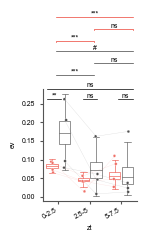

In [105]:
npairs_thresh = 100
boot_save_append = f"_min{npairs_thresh}pairs"

### This data calculates EV in 900 second windows (15 min) and then averages across it all which does NOT give the same value as
### calculating for the entire 2.5 hour block in one go. Left here for posterity.
# df_comb = np.load(grp_data_dir / "ev_in_chunks.npy", allow_pickle=True).item()[0]
# df_comb = pd.DataFrame(np.load(grp_data_dir / "ev_in_chunks.npy", allow_pickle=True),
#                        columns=["zt", "ev", "Animal", "grp", "npairs"])

# Loading in ev_chunk_df (calculated above) does the job, calculating EV in a consistent manner
df_comb = ev_chunk_df
boot_df = pd.DataFrame(np.load(grp_data_dir / f"ev_in_chunks_bootstrap{boot_save_append}.npy", allow_pickle=True), 
                       columns=["zt", "ev", "grp"])

# fig, ax = plt.subplots()
fig = subjects.SdFig().fig3()
ax = fig.subplot(fig.gs[:2, 4])
p1 = Plotter(data=boot_df, x="zt", y="ev", hue="grp", hue_order=["PBS/SAL", "ROL"], ax=ax)
p1.boxplot_sd2(legend=True, palette=colors_grp).stat_anot_sd(
    stat_within=get_bootstrap_prob_paired,
    stat_across=get_bootstrap_prob,
    alpha_across=[0.05, 0.01, 0.001],
    alpha_within=[0.025, 0.005, 0.0005],
    fontsize=5,
    pair_names=["PBS/SAL", "ROL"],
    verbose=True,
)

df_use = df_comb[df_comb.grp != "OCT"]
df_use = df_use[df_use.npairs > npairs_thresh]
# sns.stripplot(data=df_use, x="block", y="ev_mean", hue="session", dodge=True, 
#               edgecolor="w", linewidth=0.2, ax=ax)
p2 = Plotter(data=df_use, x="zt", y="ev", hue="grp", hue_order=["PBS/SAL", "ROL"], ax=ax)
p2.striplineplot_sd(palette=colors_grp_light, units="Animal")
# p2.striplineplot_sd()

fig.savefig(plot_save_dir / f"ROL_v_SAL_ev_in_blocks{boot_save_append}.pdf")

## Power Analysis
1) Calculate weighted mean and std due to vast differences in # of neuron-pairs.
2) Do brute force power analysis by adding in an additional animal to each group until you get p < 0.05 for first block and then for second block

In [9]:
# Define lambda functions to get weighted mean and standard deviation
from statsmodels.stats.weightstats import DescrStatsW
weighted_mean = lambda df: DescrStatsW(df.ev_mean, weights=df.npairs, ddof=0).mean
weighted_std = lambda df: DescrStatsW(df.ev_mean, weights=df.npairs, ddof=0).std

In [12]:
ev_sd = np.load(grp_data_dir / "ev_in_chunks_sd.npy", allow_pickle=True).item()
ev_sd = pd.DataFrame(ev_sd["data"])
ev_sd.sample(6)

,ev,rev,ev_diff,ev_perc,zt,session,name,sex,grp
8,0.118485,0.001448,0.117037,8083.720061,5-7.5,2,RatSDay2,female,NSD
28,0.000131,0.000009,0.000123,1432.451371,2.5-5,9,RatUDay1,male,SD
12,0.193894,0.026556,0.167338,630.120696,0-2.5,4,RatVDay1,male,NSD
3,0.127305,0.009345,0.117960,1262.346708,0-2.5,1,RatNDay2,female,NSD
4,0.060773,0.001153,0.059620,5171.189227,2.5-5,1,RatNDay2,female,NSD
37,0.011070,0.050522,-0.039452,-78.088178,2.5-5,12,RatRDay2,female,SD


In [13]:
ev_sd_stats = ev_sd.drop(columns=["rev", "ev_diff", "ev_perc", "session", "name", "sex"]).groupby(["grp", "zt"]).count().rename(columns={"ev": "n"}).reset_index()
ev_sd_stats["ev_mean"] = ev_sd.groupby(["grp", "zt"]).mean(numeric_only=True).reset_index()["ev"]
ev_sd_stats["ev_std"] = ev_sd.groupby(["grp", "zt"]).std(numeric_only=True).reset_index()["ev"]
ev_sd_stats

,grp,zt,n,ev_mean,ev_std
0,NSD,0-2.5,6,0.155618,0.084213
1,NSD,2.5-5,6,0.067306,0.035342
2,NSD,5-7.5,6,0.073258,0.085710
3,SD,0-2.5,7,0.074081,0.081213
4,SD,2.5-5,7,0.016285,0.016965
5,SD,5-7.5,7,0.037279,0.004609


In [14]:
import itertools
def get_tstats_win_grp(df_in, grp, zt_list = ["0-2.5", "2.5-5", "5-7.5"]):
    """Calculate within group stats"""
    tstat = []
    cohen_d = []
    dof = []
    pval = []
    blk0_mean, blk1_mean = [], []
    blk0, blk1 = [], []
    
    df_use = df_in[df_in.grp == grp]
    for zt0, zt1 in itertools.combinations(zt_list, 2):
        
        df_grp0 = df_use[df_use.zt == zt0].reset_index()
        df_grp1 = df_use[df_use.zt == zt1].reset_index()

        tstat.append(((df_grp0.ev_mean - df_grp1.ev_mean) / 
                      np.sqrt(df_grp0.ev_std ** 2 / df_grp0.n + df_grp1.ev_std ** 2 / df_grp1.n))
                     .values[0])
        cohen_d.append(((df_grp0.ev_mean - df_grp1.ev_mean) / 
                      np.sqrt(((df_grp0.n - 1) * df_grp0.ev_std ** 2 + (df_grp1.n - 1) * df_grp1.ev_std ** 2 ) / (df_grp0.n + df_grp1.n)))
                      .values[0])
        
        dof.append(((df_grp0.ev_std ** 2 / df_grp0.n + df_grp1.ev_std ** 2 / df_grp1.n) ** 2 / 
                   (df_grp0.ev_std ** 4 / (df_grp0.n ** 2) / (df_grp0.n - 1) + df_grp1.ev_std ** 4 / (df_grp1.n ** 2) / (df_grp1.n - 1))).values[0])
        pval.append(2 * (1 - stats.t.cdf(np.abs(tstat[-1]), dof[-1])))
        blk0.append(zt0)
        blk1.append(zt1)
        blk0_mean.append(df_grp0.ev_mean.values[0])
        blk1_mean.append(df_grp1.ev_mean.values[0])
        
    return pd.DataFrame({"grp": grp, "block0": blk0, "block1": blk1 , "block0_mean": blk0_mean, "block1_mean": blk1_mean,
                         "tstat": tstat, "dof": dof, "pval": pval, "Cohens-d": cohen_d})
get_tstats_win_grp(ev_sd_stats, "NSD")

,grp,block0,block1,block0_mean,block1_mean,tstat,dof,pval,Cohens-d
0,NSD,0-2.5,2.5-5,0.155618,0.067306,2.368581,6.708270,0.051244,1.498022
1,NSD,0-2.5,5-7.5,0.155618,0.073258,1.678949,9.996898,0.124096,1.061861
2,NSD,2.5-5,5-7.5,0.067306,0.073258,-0.157259,6.652516,0.879707,-0.099459


In [22]:
def get_tstats(df_in, grps = ["NSD", "SD"], zt_list = ["0-2.5", "2.5-5", "5-7.5"]):
    """Handwritten function to get t-stats, checks out with scipy.stats"""
    tstat = []
    cohen_d = []
    dof = []
    pval = []
    grp0_mean, grp1_mean = [], []
    for zt in zt_list:
        df_use = df_in[df_in.zt == zt]
        df_grp0 = df_use[df_use.grp == grps[0]].reset_index()
        df_grp1 = df_use[df_use.grp == grps[1]].reset_index()
        tstat.append(((df_grp0.ev_mean - df_grp1.ev_mean) / 
                      np.sqrt(df_grp0.ev_std ** 2 / df_grp0.n + df_grp1.ev_std ** 2 / df_grp1.n))
                     .values[0])
        cohen_d.append(((df_grp0.ev_mean - df_grp1.ev_mean) / 
                      np.sqrt(((df_grp0.n - 1) * df_grp0.ev_std ** 2 + (df_grp1.n - 1) * df_grp1.ev_std ** 2 ) / (df_grp0.n + df_grp1.n)))
                      .values[0])
        
        dof.append(((df_grp0.ev_std ** 2 / df_grp0.n + df_grp1.ev_std ** 2 / df_grp1.n) ** 2 / 
                   (df_grp0.ev_std ** 4 / (df_grp0.n ** 2) / (df_grp0.n - 1) + df_grp1.ev_std ** 4 / (df_grp1.n ** 2) / (df_grp1.n - 1))).values[0])
        pval.append(2 * (1 - stats.t.cdf(np.abs(tstat[-1]), dof[-1])))
        grp0_mean.append(df_grp0.ev_mean.values[0])
        grp1_mean.append(df_grp1.ev_mean.values[0])

    # Now do grp0 0-2.5 vst grp1 5-7.5
    df_use = df_in
    for zt0, zt1 in zip([zt_list[0], zt_list[-1]], [zt_list[-1], zt_list[0]]):
        df_grp0 = df_use[(df_use.grp == grps[0]) & (df_use.zt == zt0)].reset_index()
        df_grp1 = df_use[(df_use.grp == grps[1]) & (df_use.zt == zt1)].reset_index()
        tstat.append(((df_grp0.ev_mean - df_grp1.ev_mean) / 
                      np.sqrt(df_grp0.ev_std ** 2 / df_grp0.n + df_grp1.ev_std ** 2 / df_grp1.n))
                     .values[0])
        cohen_d.append(((df_grp0.ev_mean - df_grp1.ev_mean) / 
                      np.sqrt(((df_grp0.n - 1) * df_grp0.ev_std ** 2 + (df_grp1.n - 1) * df_grp1.ev_std ** 2 ) / (df_grp0.n + df_grp1.n)))
                      .values[0])
        
        dof.append(((df_grp0.ev_std ** 2 / df_grp0.n + df_grp1.ev_std ** 2 / df_grp1.n) ** 2 / 
                   (df_grp0.ev_std ** 4 / (df_grp0.n ** 2) / (df_grp0.n - 1) + df_grp1.ev_std ** 4 / (df_grp1.n ** 2) / (df_grp1.n - 1))).values[0])
        pval.append(2 * (1 - stats.t.cdf(np.abs(tstat[-1]), dof[-1])))
        grp0_mean.append(df_grp0.ev_mean.values[0])
        grp1_mean.append(df_grp1.ev_mean.values[0])
        zt_list.append(f"{zt0} v {zt1}")
    
        
    return pd.DataFrame({"zt": zt_list, f"{grps[0]}mean": grp0_mean, f"{grps[1]}mean": grp1_mean,
                         "tstat": tstat, "dof": dof, "pval": pval, "Cohens-d": cohen_d})

get_tstats(ev_sd_stats)

,zt,NSDmean,SDmean,tstat,dof,pval,Cohens-d
0,0-2.5,0.155618,0.074081,1.769123,10.557909,0.105707,1.073253
1,2.5-5,0.067306,0.016285,3.231385,6.944417,0.014583,2.060281
2,5-7.5,0.073258,0.037279,1.026975,5.024794,0.351305,0.675704
3,0-2.5 v 5-7.5,0.155618,0.037279,3.437694,5.025684,0.018331,2.261809
4,5-7.5 v 0-2.5,0.073258,0.074081,-0.017679,10.483090,0.986227,-0.010741


In [108]:
# Get t-stats for Rolipram
# df_comb = pd.DataFrame(np.load(grp_data_dir / "ev_in_chunks.npy", allow_pickle=True),
#                        columns=["zt", "ev_mean", "session", "grp", "npairs"])
df_comb = ev_chunk_df
df_comb = df_comb.rename(columns={"ev": "ev_mean"})
df_comb = df_comb[df_comb.grp != "OCT"]
df_comb["ev_mean"] = df_comb["ev_mean"].astype("float")
df_rol_stats = df_comb[~np.isnan(df_comb.ev_mean)].groupby(["grp", "zt"]).apply(weighted_mean).reset_index().rename(columns={0: "ev_mean"})
df_rol_stats["ev_std"] = df_comb[~np.isnan(df_comb.ev_mean)].groupby(["grp", "zt"]).apply(weighted_std).reset_index()[0]
df_rol_stats["n"] = df_comb[~np.isnan(df_comb.ev_mean)].groupby(["grp", "zt"]).count().reset_index()["ev_mean"]
df_rol_stats

,grp,zt,ev_mean,ev_std,n
0,PBS/SAL,0-2.5,0.082827,0.018158,5
1,PBS/SAL,2.5-5,0.046680,0.024777,5
2,PBS/SAL,5-7.5,0.069556,0.028231,5
3,ROL,0-2.5,0.172784,0.087671,4
4,ROL,2.5-5,0.103052,0.055460,4
5,ROL,5-7.5,0.097580,0.071071,4


In [109]:
# Iterate through, adding an additional animal to each group and calculate tstat and pvalue assuming the same mean and variance
from copy import deepcopy
df_iter = []
for n in np.arange(0, 5, 1):
    df_use = deepcopy(df_rol_stats)
    df_use["n"] = df_use["n"] + n
    nsal = df_use[df_use.grp == "PBS/SAL"]["n"].values[0]
    nrol = df_use[df_use.grp == "ROL"]["n"].values[0]
    tstats_df = get_tstats(df_use, grps=["PBS/SAL", "ROL"], zt_list=["0-2.5", "2.5-5", "5-7.5"])
    tstats_df["nPBS/SAL"] = nsal
    tstats_df["nROL"] = nrol
    df_iter.append(tstats_df)
power_df = pd.concat(df_iter, axis=0, ignore_index=True)
power_df = power_df.rename(columns={"pval": "pval (2-sided)"})
power_df.to_csv(grp_data_dir / "power_analysis.csv")
power_df.to_csv(plot_save_dir / "power_analysis_bw_grps.csv")
power_df

,zt,PBS/SALmean,ROLmean,tstat,dof,pval (2-sided),Cohens-d,nPBS/SAL,nROL
0,0-2.5,0.082827,0.172784,-2.017831,3.206600,0.131031,-1.728481,5,4
1,2.5-5,0.046680,0.103052,-1.887772,3.958806,0.132832,-1.564626,5,4
2,5-7.5,0.069556,0.097580,-0.743115,3.760238,0.501147,-0.620782,5,4
3,0-2.5 v 5-7.5,0.082827,0.097580,-0.404734,3.314722,0.710395,-0.344851,5,4
4,5-7.5 v 0-2.5,0.069556,0.172784,-2.262917,3.500290,0.095937,-1.911544,5,4
5,0-2.5,0.082827,0.172784,-2.254446,4.286701,0.082741,-1.657700,6,5
6,2.5-5,0.046680,0.103052,-2.104565,5.323424,0.085856,-1.507953,6,5
7,5-7.5,0.069556,0.097580,-0.828895,5.051199,0.444554,-0.597608,6,5
8,0-2.5 v 5-7.5,0.082827,0.097580,-0.452039,4.436501,0.672472,-0.330999,6,5
9,5-7.5 v 0-2.5,0.069556,0.172784,-2.525990,4.693098,0.055931,-1.837151,6,5


In [110]:
# Get w/in group parametric stats and effect size
df_ctrl = get_tstats_win_grp(df_rol_stats, "PBS/SAL")
df_rol = get_tstats_win_grp(df_rol_stats, "ROL")
df_win = pd.concat((df_ctrl, df_rol), axis=0, ignore_index=True)
df_win.to_csv(plot_save_dir / "stats_win_grps.csv")
df_win

,grp,block0,block1,block0_mean,block1_mean,tstat,dof,pval,Cohens-d
0,PBS/SAL,0-2.5,2.5-5,0.082827,0.046680,2.631232,7.334725,0.032476,1.860562
1,PBS/SAL,0-2.5,5-7.5,0.082827,0.069556,0.884062,6.825915,0.406722,0.625127
2,PBS/SAL,2.5-5,5-7.5,0.046680,0.069556,-1.361805,7.867498,0.210971,-0.962942
3,ROL,0-2.5,2.5-5,0.172784,0.103052,1.344360,5.069595,0.235851,1.097666
4,ROL,0-2.5,5-7.5,0.172784,0.097580,1.332712,5.753724,0.232970,1.088154
5,ROL,2.5-5,5-7.5,0.103052,0.097580,0.121411,5.665321,0.907557,0.099132
